# Graph embedding using SkipGram

This is an embedding of the whole graph, 80/20 training and validation split and all sources

kg-covid-19:
version 20201012

Name: ensmallen-graph
Version: 0.4.4

Name: embiggen
Version: 0.6.0

In [1]:
from pkg_resources import get_distribution
assert(get_distribution("ensmallen-graph").version == '0.4.4')  # identical to 0.4.3 except for addition of some methods like get_edge_id()
assert(get_distribution("embiggen").version == '0.6.0')

In [2]:
import os

exp_name = "no_split_kg_covid_19_20201012_training_test_epoch_500_delta_0.0001"
s3_path = "s3://kg-hub-public-data/embeddings/20201012/"  # keep trailing slash

base_dl_dir = "downloaded_data"
graph_data_dir = os.path.join(base_dl_dir, "kg-covid-19-20201012")
embedding_data_dir = os.path.join(base_dl_dir, "embeddings-20201012")

# graph stuff
graph_out_file = os.path.join(graph_data_dir + "/kg-covid-19.tar.gz")
nodes_file = os.path.join(graph_data_dir, "merged-kg_nodes.tsv")
edges_file = os.path.join(graph_data_dir, "merged-kg_edges.tsv")
sorted_edges_file = os.path.join(graph_data_dir, "merged-kg_edges_SORTED.tsv")
graph_tar_url = "https://kg-hub.berkeleybop.io/kg-covid-19/20201012/kg-covid-19.tar.gz"

# embeddings URLs
base_kghub_url = "http://kg-hub.berkeleybop.io/"
embeddings_url = os.path.join(base_kghub_url, "embeddings/20201012/SkipGram_80_20_kg_covid_19_20201012_training_test_epoch_500_delta_0.0001_embedding.npy")
embedding_file = os.path.join(embedding_data_dir, "SkipGram_embedding.npy")

# params
seed = 42
train_percentage = 0.8
patience = 6

In [3]:
import silence_tensorflow.auto # Import needed to avoid TensorFlow warnings and general useless infos.

## Loading the graphs
We load the kg-covid-19 graph from the repository as an undirected graph.

In [4]:
# get the graphs, if necessary

import urllib
import os
os.makedirs(graph_data_dir, exist_ok=True)

if not os.path.exists(nodes_file) or not os.path.exists(edges_file):
    with urllib.request.urlopen(graph_tar_url) as response, \
        open(graph_out_file, 'wb') as out_file:
            data = response.read()  # a `bytes` object
            out_file.write(data)
    os.system("tar -xvzf " + graph_out_file + " -C " + graph_data_dir)

#### only need to do this once, b/c we'll load the sorted.tsv from now on once it is made below

In [5]:
%%time
from ensmallen_graph import EnsmallenGraph

if not os.path.exists(sorted_edges_file):
    graph = EnsmallenGraph.from_unsorted_csv(
        edge_path = graph_data_dir + "/merged-kg_edges.tsv",
        sources_column="subject",
        destinations_column="object",
        directed=False,
        node_path = graph_data_dir + "/merged-kg_nodes.tsv",
        nodes_column = 'id',
        node_types_column = 'category',
        default_node_type = 'biolink:NamedThing'
    )

    graph.dump_edges(sorted_edges_file,
        sources_column="subject",
        destinations_column="object")

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 1.88 ms


In [6]:
from ensmallen_graph import EnsmallenGraph
 
graph = EnsmallenGraph.from_sorted_csv(
    edge_path = sorted_edges_file,
    sources_column="subject",
    destinations_column="object",
    directed=False,
    nodes_number=447766,  # should be = or > than actual number
    edges_number=42000000,   # same ^
    node_path = nodes_file,
    nodes_column = 'id',
    node_types_column = 'category',
    default_node_type = 'biolink:NamedThing'
)

graph.report()

{'edges_number': '31223434',
 'singletons': '8355',
 'has_node_types': 'true',
 'directed': 'false',
 'density': '0.010673045865565448',
 'name': 'Graph',
 'unique_edge_types_number': '0',
 'has_weights': 'false',
 'degree_mean': '69.73158748096104',
 'nodes_number': '447766',
 'has_edge_types': 'false',
 'self_loops_rate': '0.000015373068830289457',
 'undirected_edges_number': '15611957',
 'self_loops_number': '480',
 'unique_node_types_number': '42'}

In [7]:
graph.enable_fast_walk()

The followings are check that are not necessary, but are offered as sanity checks:

### Considered parameters
We are going to use the following parameters:

- **Walk lengths:** $100$ nodes.
- **Batch size:** $2^{7} = 128$ walks per batch.
- **Walk iterations:** $20$ iterations on the graph.
- **Window size:** $4$ nodes, meaning $4$ on the left and $4$ on the right of the center nodes. Consider that the first *window_size* values on the left and the right of the walks will be trimmed.
- **Return weight, inverse of $p$:** $1.0$.
- **Explore weight, inverse of $q$:** $1.0$.
- **Embedding size:** $100$.
- **Negative samples:** For the porpose of the [NCE function negative samples](https://www.tensorflow.org/api_docs/python/tf/nn/nce_loss), we are going to use $10$. These are the number of negative classes to randomly sample per batch. This single sample of negative classes is evaluated for each element in the batch.
- **Optimizer:** [Nadam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Nadam).
- **Early stopping parameters:** We are going to use an Early Stopping criterion on the *validation loss*, with patience $5$ and delta $0.0001$.
- **Epochs:** The model will be trained up to $1000$ epochs.
- **Learning rate:** default

#### Setting up the parameters

In [8]:
walk_length=100
batch_size=2**9
iterations=20
window_size=4
p=1.0
q=1.0
embedding_size=100
negative_samples=30
patience=5
delta=0.0001
epochs=500
learning_rate=0.1

#### Creating the training and validation Keras sequences

## Creating the SkipGram model
We are going to setup the model to use, if available, multiple GPUs.

In [9]:
from embiggen import Node2VecSequence

graph_sequence = Node2VecSequence(
    graph,
    walk_length=walk_length,
    batch_size=batch_size,
    iterations=iterations,
    window_size=window_size,
    return_weight=1/p,
    explore_weight=1/q
)

In [10]:
from tensorflow.distribute import MirroredStrategy
from tensorflow.keras.optimizers import Nadam
from embiggen import SkipGram

# strategy = MirroredStrategy()
# with strategy.scope():
model = SkipGram(
    vocabulary_size=graph.get_nodes_number(),
    embedding_size=embedding_size,
    window_size=window_size,
    negative_samples=negative_samples,
    optimizer=Nadam(learning_rate)
)

model.summary()

Model: "SkipGram"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
words_embedding (InputLayer)    [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 100)       44776600    words_embedding[0][0]            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 100)          0           embedding[0][0]                  
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 8)]          0                                            
___________________________________________________________________________________________

## Tuning the SkipGram model

In [11]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


history = model.fit(
    graph_sequence,
    steps_per_epoch=graph_sequence.steps_per_epoch,
    epochs=epochs,
    callbacks=[
        EarlyStopping(
            monitor="loss",
            min_delta=delta,
            patience=patience,
            restore_best_weights=True
        ),
        ReduceLROnPlateau(
            monitor="loss",
            patience=patience//2,
            min_delta=delta
        )
    ]
)

Epoch 1/500
859/859 [==============================] - 879s 1s/step - loss: 123.2891
Epoch 2/500
859/859 [==============================] - 863s 1s/step - loss: 101.3660
Epoch 3/500
859/859 [==============================] - 857s 998ms/step - loss: 91.2328
Epoch 4/500
859/859 [==============================] - 854s 995ms/step - loss: 84.7336
Epoch 5/500
859/859 [==============================] - 850s 990ms/step - loss: 79.6762
Epoch 6/500
859/859 [==============================] - 848s 988ms/step - loss: 77.1776
Epoch 7/500
859/859 [==============================] - 853s 993ms/step - loss: 72.3052
Epoch 8/500
859/859 [==============================] - 845s 984ms/step - loss: 70.1852
Epoch 9/500
859/859 [==============================] - 844s 983ms/step - loss: 68.0439
Epoch 10/500
859/859 [==============================] - 839s 977ms/step - loss: 63.7876
Epoch 11/500
859/859 [==============================] - 834s 971ms/step - loss: 62.7742
Epoch 12/500
859/859 [=======================

### Saving the model weights

In [12]:
weights_file = f"{model.name}_" + exp_name + "_weights.h5"
model.save_weights(weights_file)

### Visualizing the training history
We can visualize the performance of the model during the training process as follows:

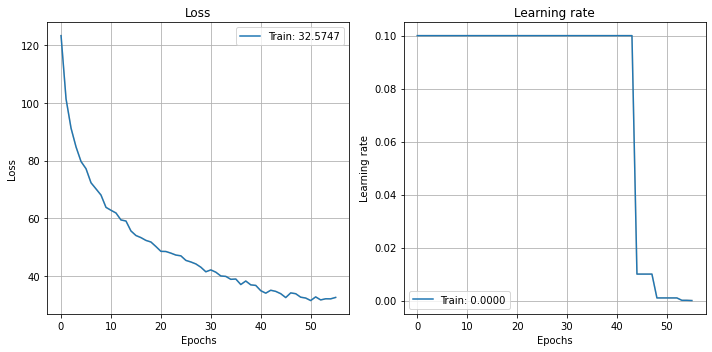

In [13]:
from plot_keras_history import plot_history

plot_history(history)

There may be some hiccups in the plot of the history if the model is reloaded from stored weights: [this is a known Keras issue](https://github.com/keras-team/keras/issues/4875) and is not related to either the holdouts used or the model.

## Saving the obtained embeddings
Finally we save our hard earned model embeddings. In another notebook we will show how to do link prediction on the obtained embedding.

In [14]:
import numpy as np
new_embedding_file = f"{model.name}_" + exp_name + "_embedding.npy"
np.save(new_embedding_file, model.embedding)

## Upload the weights and embeddings

In [15]:
os.system(f"s3cmd put --acl-public --cf-invalidate {new_embedding_file} {s3_path}")

0

In [16]:
os.system(f"s3cmd put --acl-public --cf-invalidate {weights_file} {s3_path}")

0